# NYC Taxi Example — Educational Walkthrough

## Purpose
This notebook demonstrates how to load, explore, and analyze the NYC Taxi dataset using Apache Spark (PySpark). The goal is educational: to explain each step, the reasoning, common pitfalls, and for each step to have a detiled look into Spark.UI to better understand the general processes of Spark.

## What you'll learn
- understand how Apache Spark Architecture works
- How to set up a Spark session for local development.
- Basic exploratory data analysis (aggregations, distributions, time-series).
- Simple performance tips for Spark on a laptop.
- Common errors and how to debug them.

## Prerequisites
- Python 3.7+ and PySpark installed, or a working Spark distribution available.
- Enough RAM (at least a few GB) for local testing. For large files, prefer Parquet and sample data.
- The notebook expects the taxi data files to be reachable by the local filesystem or HDFS. Adjust paths accordingly.

## Dataset summary
This example uses the NYC Taxi trip dataset. Typical columns include:
- tpep_pickup_datetime, tpep_dropoff_datetime (timestamps)
- passenger_count (integer)
- trip_distance (float)
- PULocationID, DOLocationID (integers referring to taxi zone IDs)
- fare_amount, tip_amount, total_amount (floats)

If your file is CSV, prefer reading with an explicit schema to avoid costly type inference.

## How this notebook is organized
1. Environment and Spark session setup (create SparkSession, set configs).
2. Data schema & loading (CSV/Parquet, sample vs full data).
3. Data cleaning and type casting (timestamp parsing, null handling).
4. Exploratory analysis (counts, top pickup/dropoff zones, trip distance distribution).
5. Time-based analysis (hourly/daily trends).
6. Example aggregation queries (revenue by zone, average tip percent).
7. Small exercises for practice.

## Walkthrough notes (what to look for in the code cells)
- SparkSession: look for `SparkSession.builder` and `appName` configuration. If running locally, `master("local[*]")` is typically used.
- Reading CSV: prefer `spark.read.csv(path, schema=SCHEMA, header=True)` with `schema` defined as `StructType(...)` to avoid `inferSchema=True` overhead.
- Timestamps: convert pickup/dropoff string columns to Spark `TimestampType` using `to_timestamp()` or `unix_timestamp()` then cast.
- Nulls and filters: filter out rows with impossible values (e.g., trip_distance <= 0, fare_amount < 0) and handle missing zones.
- Caching: cache intermediate DataFrames used multiple times (e.g., cleaned DF) to avoid repeated I/O.
- Partitioning & file format: for repeated analysis, store cleaned data as Parquet and partition by year/month for faster reads.

## Expected outputs and checks
- Schema should show timestamps and numeric types for fare/trip distance.
- Typical aggregate: top 10 pickup zones by trip count.
- Time-series plots (if rendered) should show daily/weekly patterns; morning and evening peaks are common.

## Common pitfalls & debugging tips
- Memory errors: reduce data by sampling (`df.sample(0.01)`) or increase local executor memory via Spark conf.
- Slow CSV reads: switch to Parquet or provide explicit schema.
- Timezone issues: be aware of timezone in timestamps; dataset timestamps are usually in local NY time.
- Missing zone ID mapping: if mapping zone IDs to names, ensure the mapping file is the correct version for your taxi year.

## Exercises (try these after running the notebook)
1. Compute the average tip percentage by pickup hour and plot it. What hours have the highest tip rates?
2. Find the top 5 origin-destination pairs by total revenue.
3. Create a cleaned Parquet dataset partitioned by year and month, then re-run the top pickup zones query against the partitioned dataset and compare read times.

## Further reading & references
- Official Apache Spark docs: https://spark.apache.org/docs/latest/
- NYC Taxi & Limousine Commission (TLC) Trip Record Data: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

---

Continue through the notebook cells below. Each code cell includes inline comments; read them slowly and execute cells in order. If you'd like, I can also:
- Insert explanatory Markdown cells before each major code section.
- Convert key code cells to smaller step-by-step cells with assertions and unit-tests.

Tell me if you want the notebook annotated further (for example, add visualizations with matplotlib/plotly, or convert all data reads to explicit-schema Parquet reads).

## Create a Spark Session:
`.config("spark.ui.port", "4040")` creates a Spark UI under Port 4040

## Section: Environment & Spark session setup

This cell creates the SparkSession and sets runtime configuration for local execution. Run this first to initialize Spark. If you run into memory issues, decrease local cores or increase executor memory via Spark configs.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NYC Taxi Insights") \
    .master("local[*]") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

### Reduce number of partitions for low-level PCs

## Section: Data loading

This cell reads the taxi dataset from CSV or Parquet. Prefer passing an explicit schema when reading CSV to avoid slow type inference. Adjust file paths to your local dataset.

In [2]:
# Standardwert ist 200
spark.conf.get("spark.sql.shuffle.partitions")
# -> '200'

'200'

## Section: Data cleaning & type casting

This section parses timestamps, casts types, and filters out invalid rows (e.g., negative fares or zero-distance trips). These steps make downstream aggregations reliable.

In [3]:
# Anpassung
spark.conf.set("spark.sql.shuffle.partitions", "20")

### load data

## Section: Initial exploration & simple queries

Run basic counts and group-bys to get a feel for the data shape: top pickup zones, distribution of trip distances, and passenger counts.

In [4]:
df = spark.read.parquet("C:/Data/NYC_TLC_Trip_Records/yellow_tripdata_2025-01.parquet")
df.printSchema()
df.show(5)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+------

## Section: Visualization

This section converts Spark DataFrames to Pandas for plotting small samples. Use plotting libraries (matplotlib/plotly) for time-series and distribution visualizations. Avoid converting very large DataFrames to Pandas.

In [5]:
import os

total_size = 0
directory = r"C:\Data\NYC_TLC_Trip_Records"

for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    if os.path.isfile(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)  # in MB
        print(f"{filename:40} {size_mb:10.2f} MB")
        total_size += size_mb

print(round(total_size),"MB")

yellow_tripdata_2025-01.parquet               56.42 MB
yellow_tripdata_2025-02.parquet               57.55 MB
yellow_tripdata_2025-03.parquet               66.72 MB
181 MB


## Section: Aggregations & business metrics

Compute revenue, average fare, and tip percent by zone/hour. These queries demonstrate common business metrics and show how to use window functions and joins in Spark.

## Section: Save / Export cleaned data

Save cleaned and partitioned data to Parquet for repeated analysis. Partition by year/month to speed up queries that filter by time ranges.

In [6]:
from pyspark.sql.functions import col, count, avg, max, min

# Anzahl der Fahrten
total_trips = df.count()

# Durchschnittliche Distanz und Dauer
avg_distance = df.agg(avg("trip_distance")).first()[0]
avg_fare = df.agg(avg("fare_amount")).first()[0]

print(f"🚖 Gesamtfahrten: {total_trips:,}")
print(f"📏 Durchschnittliche Distanz: {avg_distance:.2f} miles")
print(f"💵 Durchschnittlicher Fahrpreis: ${avg_fare:.2f}")

🚖 Gesamtfahrten: 3,475,226
📏 Durchschnittliche Distanz: 5.86 miles
💵 Durchschnittlicher Fahrpreis: $17.08


In [7]:
from pyspark.sql.functions import hour, dayofweek

# Anzahl Fahrten pro Stunde
trips_per_hour = df.withColumn("hour", hour("tpep_pickup_datetime")) \
    .groupBy("hour").count().orderBy("hour")
trips_per_hour.show()

+----+------+
|hour| count|
+----+------+
|   0| 93417|
|   1| 64484|
|   2| 43929|
|   3| 28492|
|   4| 20033|
|   5| 22551|
|   6| 50026|
|   7|102581|
|   8|141305|
|   9|142877|
|  10|148316|
|  11|160076|
|  12|175432|
|  13|186144|
|  14|202289|
|  15|213694|
|  16|217051|
|  17|253518|
|  18|267951|
|  19|221055|
+----+------+
only showing top 20 rows



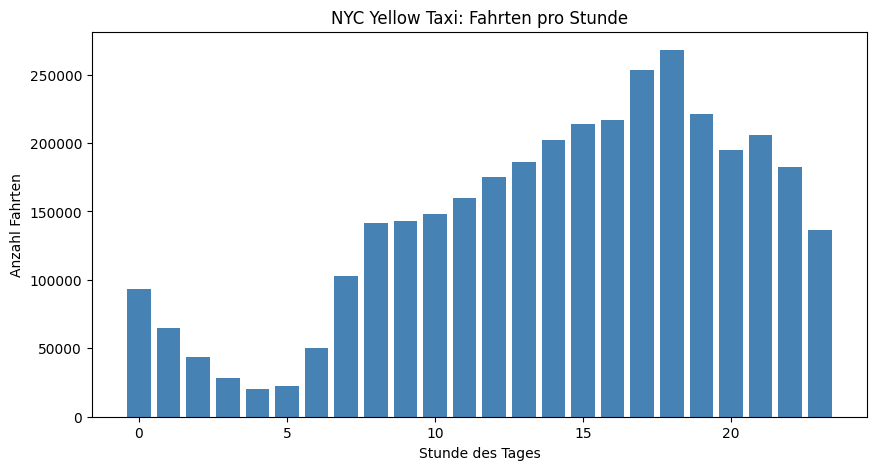

In [8]:
import matplotlib.pyplot as plt

# Fahrten pro Stunde
pdf = trips_per_hour.toPandas()

plt.figure(figsize=(10,5))
plt.bar(pdf["hour"], pdf["count"], color="steelblue")
plt.xlabel("Stunde des Tages")
plt.ylabel("Anzahl Fahrten")
plt.title("NYC Yellow Taxi: Fahrten pro Stunde")
plt.show()

In [9]:
pickup_counts = df.groupBy("PULocationID").count().orderBy(col("count").desc())
pickup_counts.show(10)

+------------+------+
|PULocationID| count|
+------------+------+
|         161|169977|
|         237|163703|
|         236|155647|
|         132|146137|
|         230|125829|
|         186|119131|
|         162|117930|
|         142|110585|
|         239| 96614|
|         163| 95906|
+------------+------+
only showing top 10 rows

